<a href="https://colab.research.google.com/github/MigMikael/fianacial_extract/blob/main/GenAI_Financial_Report_Taxonomy_extractions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **GenAI Financial Report Taxonomy extractions**

---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GoogleCloudPlatform/python-docs-samples/blob/main/cloud-sql/postgres/pgvector/notebooks/pgvector_gen_ai_demo.ipynb)

This hands-on tutorial will show you how you can add generative AI features to your own applications using Gemini Vertex AI, Vertex AI Search on Google Cloud.

We will build together a sample Python application that will be able to load Taxonomy table to Vertex AI Search Datastore, extract/mapping financial report tables from XLSX with LLM and Taxonomy data.


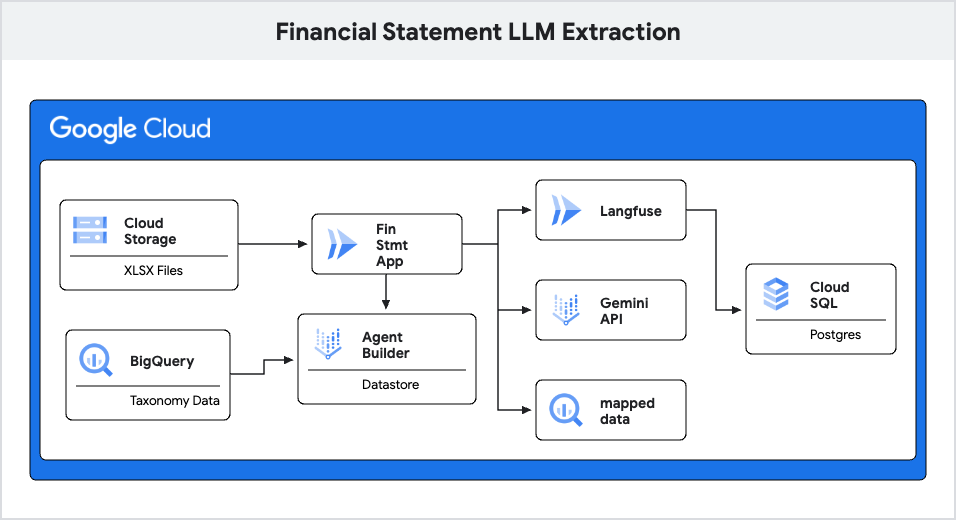

## Before you begin

>⚠️ **Running this codelab will incur Google Cloud charges. You may also be billed for Vertex AI API usages.**

Pre-requisities:
- You need to have an active Google Cloud account to successfully complete this tutorial.
-  This sample notebook must be connected to a **Google Cloud project**, but nothing else is needed other than your Google Cloud project.
- You can use an existing project. Alternatively, you can create a new Cloud project [with free trial cloud credits.](https://cloud.google.com/free/docs/gcp-free-tier)
- At the end of the tutorial, you can optionally clean-up these resources to avoid further charges.


### Using this interactive notebook

Click the **run** icon on the top left corner ▶️  of each cell within this notebook.

> 💡 Alternatively, you can run the currently selected cell with `Ctrl + Enter` (or `⌘ + Enter` on a Mac).

> ⚠️ **To avoid any errors**, wait for each cell to finish in their order before clicking the next “run” icon.

## Setup

### Install required packages

>⚠️ You may receive a warning to "Restart Runtime" after the packages are installed. Don't worry, the subsequent cells will help you restart the runtime.

In [ ]:
# Install dependencies.
!pip install --upgrade --quiet \
    langchain-community \
    langchain-core \
    langchain-google-vertexai==1.0.8 \
    langchain-google-community==1.0.7 \
    langchain-google-community[vertexaisearch] \
    google-cloud-discoveryengine \
    google-cloud-aiplatform==1.62.0 \
    unstructured[all-docs] \
    openpyxl \
    nltk \
    langfuse \
    gradio \
    google-cloud-documentai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.5 MB/s eta 0:00:00
  

In [ ]:
!pip freeze | grep -e 'langchain' -e 'google-cloud-aiplatform' -e 'google-cloud-discoveryengine' -e 'langchain-community' -e 'langchain-google-vertexai' -e 'langchain-google-community'

In [ ]:
# Automatically restart kernel after installs so that your environment
# can access the new packages.
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Setup Google Cloud environment

>⚠️ Please fill in your **Google Cloud project ID** and a new **password** for your Cloud SQL PostgreSQL database.

In [ ]:
# @markdown Replace the required placeholder text below. You can modify any other default values, if you like.

# Please fill in these values.
PROJECT_ID="nuttee-lab-00" # @param {type:"string"}
LOCATION="us-central1" # @param {type:"string"}
REGION="us-central1" # @param {type:"string"}
SEARCH_ENGINE_ID="set_taxonomy" # @param {type:"string"}
DATA_STORE_LOCATION="global" # @param {type:"string"}
MAX_DOCUMENTS="5" # @param {type:"string"}
ENGINE_DATA_TYPE="1" # @param {type:"string"}

BQ_DATASET="set_taxonomy_dataset" # @param {type:"string"}
BQ_TABLE="set_taxonomy" # @param {type:"string"}
BQ_BUCKET=f"{PROJECT_ID}-{BQ_DATASET}"

DATA_STORE_ID_PREFIX="set_taxonomy" # @param {type:"string"}
DATA_STORE_ID=f"{DATA_STORE_ID_PREFIX}_{PROJECT_ID}_01"
DATA_STORE_DISPLAY_NAME="set taxonomy list" # @param {type:"string"}
SEARCH_APP_ID="set_taxonomy_app" # @param {type:"string"}
SEARCH_APP_DISPLAY_NAME="set taxonomy App" # @param {type:"string"}

CLOUDRUN_SA="cloudrun-set-taxonomy" # @param {type:"string"}
CLOUDRUN_SA_EMAIL=f"{CLOUDRUN_SA}@{PROJECT_ID}.iam.gserviceaccount.com"
CLOUDRUN_INSTANCE_NAME="fast-api-search-set-taxonomy" # @param {type:"string"}

import os

# Set environment variables
os.environ['PROJECT_ID'] = PROJECT_ID
os.environ['LOCATION'] = LOCATION
os.environ['REGION'] = REGION
os.environ['SEARCH_ENGINE_ID'] = SEARCH_ENGINE_ID
os.environ['DATA_STORE_LOCATION'] = DATA_STORE_LOCATION
os.environ['MAX_DOCUMENTS'] = MAX_DOCUMENTS
os.environ['ENGINE_DATA_TYPE'] = ENGINE_DATA_TYPE

os.environ['BQ_DATASET'] = BQ_DATASET
os.environ['BQ_TABLE'] = BQ_TABLE
os.environ['BQ_BUCKET'] = BQ_BUCKET

os.environ['DATA_STORE_ID_PREFIX'] = DATA_STORE_ID_PREFIX
os.environ['DATA_STORE_ID'] = DATA_STORE_ID
os.environ['DATA_STORE_DISPLAY_NAME'] = DATA_STORE_DISPLAY_NAME
os.environ['SEARCH_APP_ID'] = SEARCH_APP_ID
os.environ['SEARCH_APP_DISPLAY_NAME'] = SEARCH_APP_DISPLAY_NAME

os.environ['CLOUDRUN_SA'] = CLOUDRUN_SA
os.environ['CLOUDRUN_SA_EMAIL'] = CLOUDRUN_SA_EMAIL
os.environ['CLOUDRUN_INSTANCE_NAME'] = CLOUDRUN_INSTANCE_NAME

In [ ]:
#@markdown ###Authenticate your Google Cloud Account and enable APIs.
# Authenticate gcloud.
from google.colab import auth
auth.authenticate_user()

# Configure gcloud.
!gcloud config set project {PROJECT_ID}

# Grant IAM role to authenticated user
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

# Enable Cloud SQL Admin API
!gcloud services enable discoveryengine.googleapis.com
!gcloud services enable aiplatform.googleapis.com
!gcloud services enable bigquery.googleapis.com
!gcloud services enable storage.googleapis.com
!gcloud services enable run.googleapis.com
!gcloud services enable cloudresourcemanager.googleapis.com


Updated property [core/project].


In [ ]:
#!gcloud auth application-default login

### Create Bigquery Table, Vertex AI Search Strutured Datastore, and Vertex AI Search App

Download taxonomy csv and convert to jsonl

In [ ]:
%%shell
gsutil cp gs://nuttee-lab-00-genai/taxonomy/TH_Form_3_Securities.csv .
gsutil cp gs://nuttee-lab-00-genai/taxonomy/TH_Form_6_General_Business.csv .

In [ ]:
import pandas as pd

def csv_to_jsonl(csv_file):
    # Define the data types for each column
    dtype = {
        'set_code': str,
        'item_in_taxonomy': str,
        'meaning_of_taxonomy': str
    }
    # Read the CSV file with the specified data types
    df = pd.read_csv(csv_file, dtype=dtype, usecols=['set_code','item_in_taxonomy','meaning_of_taxonomy'])
    df.to_json(csv_file.replace('.csv', '.jsonl'), orient='records', lines=True, force_ascii=False)

In [ ]:
csv_to_jsonl('TH_Form_3_Securities.csv')
csv_to_jsonl('TH_Form_6_General_Business.csv')

Create a Cloud Storage Bucket and upload a jsonl products data file

In [ ]:
%%shell
gsutil ls gs://$BQ_BUCKET || PATH_EXIST=$?
echo $PATH_EXIST
if [[ ${PATH_EXIST} -eq 0 ]]; then
    echo "Bucket Exist"
else
    echo "Bucket Not Exist"
    gsutil mb -l $LOCATION gs://$BQ_BUCKET
fi


gsutil cp TH_Form_3_Securities.jsonl gs://$BQ_BUCKET/TH_Form_3_Securities.jsonl
gsutil cp TH_Form_6_General_Business.jsonl gs://$BQ_BUCKET/TH_Form_6_General_Business.jsonl

Create a Dataset on BigQuery

In [ ]:
%%shell

bq show $PROJECT_ID:$BQ_DATASET || DATASET_EXIST=$?

if [[ ${DATASET_EXIST} -eq 0 ]]; then
    echo "Dataset Exist"
else
    echo "Dataset Not Exist"
    bq --location=US mk --dataset $PROJECT_ID:$BQ_DATASET
fi

Create a Table on BigQuery

In [ ]:
%%shell

bq show $PROJECT_ID:$BQ_DATASET.$BQ_TABLE || TABLE_EXIST=$?

if [[ ${TABLE_EXIST} -eq 0 ]]; then
    echo "Table Exist"
else
    echo "Table Not Exist"
    bq --location=US load \
    --source_format=NEWLINE_DELIMITED_JSON \
    $PROJECT_ID:$BQ_DATASET.$BQ_TABLE \
    gs://$BQ_BUCKET/TH_Form_3_Securities.jsonl \
    set_code:string,item_in_taxonomy:string,meaning_of_taxonomy:string
fi

In [ ]:
%%shell

bq show $PROJECT_ID:$BQ_DATASET.${BQ_TABLE}_TH_Form_6 || TABLE_EXIST=$?

if [[ ${TABLE_EXIST} -eq 0 ]]; then
    echo "Table Exist"
else
    echo "Table Not Exist"
    bq --location=US load \
    --source_format=NEWLINE_DELIMITED_JSON \
    $PROJECT_ID:$BQ_DATASET.${BQ_TABLE}_TH_Form_6 \
    gs://$BQ_BUCKET/TH_Form_6_General_Business.jsonl \
    set_code:string,item_in_taxonomy:string,meaning_of_taxonomy:string
fi

## Vertex AI Search - Structured Datastore

Create Datastore

In [ ]:
%%shell

curl -X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
-H "X-Goog-User-Project: $PROJECT_ID" \
"https://discoveryengine.googleapis.com/v1alpha/projects/$PROJECT_ID/locations/global/collections/default_collection/dataStores?dataStoreId=${DATA_STORE_ID}" \
-d '{
  "displayName": "'"$DATA_STORE_DISPLAY_NAME"'",
  "industryVertical": "GENERIC",
  "solutionTypes": ["SOLUTION_TYPE_SEARCH"]
}'

Update datastore Schema

In [ ]:
%%shell

cat <<EOF > schema.json
{
  "structSchema":
  {
    "\$schema": "https://json-schema.org/draft/2020-12/schema",
    "type": "object",
    "properties": {
      "set_code": {
        "type": "string",
        "retrievable": true,
        "indexable": false,
        "dynamicFacetable": false,
        "searchable": false
      },
      "item_in_taxonomy": {
        "type": "string",
        "keyPropertyMapping": "title",
        "retrievable": true,
        "dynamicFacetable": false
      },
      "meaning_of_taxonomy": {
        "type": "string",
        "retrievable": true,
        "indexable": false,
        "dynamicFacetable": false,
        "searchable": false
      }
    }
  }
}
EOF

In [ ]:
%%shell

curl -X PATCH \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
--data @"schema.json" \
"https://discoveryengine.googleapis.com/v1/projects/$PROJECT_ID/locations/global/collections/default_collection/dataStores/${DATA_STORE_ID}/schemas/default_schema"

Import data from BigQuery

In [ ]:
%%shell

curl -X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
"https://discoveryengine.googleapis.com/v1/projects/$PROJECT_ID/locations/global/collections/default_collection/dataStores/${DATA_STORE_ID}/branches/0/documents:import" \
-d '{
  "bigquerySource": {
    "projectId": "'"$PROJECT_ID"'",
    "datasetId":"'"$BQ_DATASET"'",
    "tableId": "'"$BQ_TABLE"'",
    "dataSchema": "custom"
  },
  "reconciliationMode": "INCREMENTAL",
  "autoGenerateIds": "true"
}'

In [ ]:
%%shell

curl -X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
"https://discoveryengine.googleapis.com/v1/projects/$PROJECT_ID/locations/global/collections/default_collection/dataStores/${DATA_STORE_ID}/branches/0/documents:import" \
-d '{
  "bigquerySource": {
    "projectId": "'"$PROJECT_ID"'",
    "datasetId":"'"$BQ_DATASET"'",
    "tableId": "'"${BQ_TABLE}_TH_Form_6"'",
    "dataSchema": "custom"
  },
  "reconciliationMode": "INCREMENTAL",
  "autoGenerateIds": "true"
}'

Create a Search App with created datastore https://cloud.google.com/generative-ai-app-builder/docs/create-engine-es

In [ ]:
%%shell

curl -X POST \
-H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
-H "X-Goog-User-Project: $PROJECT_ID" \
"https://discoveryengine.googleapis.com/v1/projects/$PROJECT_ID/locations/global/collections/default_collection/engines?engineId=$SEARCH_APP_ID" \
-d '{
  "displayName": "'"$SEARCH_APP_DISPLAY_NAME"'",
  "dataStoreIds": ["'"${DATA_STORE_ID}"'"],
  "solutionType": "SOLUTION_TYPE_SEARCH",
  "searchEngineConfig": {
     "searchTier": "SEARCH_TIER_ENTERPRISE"
   }
}'

Test get search result (You may need to wait 5 mins on the newly created datastore)

In [ ]:
%%shell

QUERY="เงินสดและรายการเทียบเท่าเงินสด"

curl -X POST -H "Authorization: Bearer $(gcloud auth print-access-token)" \
-H "Content-Type: application/json" \
"https://discoveryengine.googleapis.com/v1/projects/$PROJECT_ID/locations/global/collections/default_collection/engines/$SEARCH_APP_ID/servingConfigs/default_search:search" \
-d '{
"query": "'"${QUERY}"'"
}'

## Test with Langchain VertexAISearchRetriver

In [ ]:
def search_structured_datastore(query: str) -> str:
    """Retrive the information of Taxomony list that help to identify SET Code from input query"""
    from langchain_community.retrievers import (
        GoogleVertexAISearchRetriever,
    )
    import json

    retriever = GoogleVertexAISearchRetriever(
        project_id=PROJECT_ID,
        search_engine_id=SEARCH_APP_ID,
        location_id=DATA_STORE_LOCATION,
        engine_data_type=1,
        max_documents=10,
    )

    results = retriever.invoke(query)

    docs = ""

    if len(results) == 0:
        return "Taxonomy Information Not Found. Please apologize and say I could not answer"
    for result in results:
        d = json.loads(result.page_content)
        docs += f"{d}\n"
        #docs += f"SET Code: {d.get('set_code')}\nItem in taxonomy: {d.get('item_in_taxonomy')}\nMeaning of taxonomy: {d.get('meaning_of_taxonomy')}\n\n"

    return docs

In [ ]:
result = search_structured_datastore(query="เงินสดและรายการเทียบเท่าเงินสด") #และรายการเทียบเท่าเงินสด

In [ ]:
print(result)

Checkpoint:
- We have extracted the semantic knowledge of the dataset and made it searchable through Agent Builder Datastore (Langchain - VertexAISearchRetriever).
- The demo will show next how you can use this semantic knowledge to answer complex natural language queries using LLM Agent using Langchain on Vertex AI aka Reasoning Engine.

## Use Gemini to assist on taxnomy mapping

In [ ]:
import base64
import json
import requests
from pprint import pprint
from IPython.display import Image, display, Markdown

import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason, GenerationConfig
import vertexai.preview.generative_models as generative_models

vertexai.init(project="nuttee-lab-00", location="us-central1")

textsi_1 = """You are a helpful assistant to review the finacial reports and compare to taxonomy list.
Ensure your answers are complete, unless the user requests a more concise approach.
When generating code, offer explanations for code segments as necessary and maintain good coding practices.
When presented with inquiries seeking information, provide answers that reflect a deep understanding of the field, guaranteeing their correctness.
For any non-english queries, respond in the same language as the prompt unless otherwise specified by the user.
For prompts involving reasoning, provide a clear explanation of each step in the reasoning process before presenting the final answer."""

generation_config = {
    "max_output_tokens": 8192,
    "temperature": 0.5,
    "top_p": 0.95,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}

def generate(
    input,
    generation_config: dict = None,
    safety_settings: dict = None,
    system_instruction: str = None,
):
  model = GenerativeModel(
    "gemini-1.5-pro-001",
    system_instruction=[system_instruction]
  )
  response = model.generate_content(
      input,
      generation_config=generation_config,
      safety_settings=safety_settings,
      stream=False,
  )

  #print(response.text, end="")

  return response

In [ ]:
query = "สินทรัพย์ทางการเงินไม่หมุนเวียนอื่น"
search_result = search_structured_datastore(query=query)
print(search_result)

In [ ]:
input = [
    """From the financial report line item name as INPUT.
Use the Taxonomy list in CONTEXT to suggest to correct SET Code and Item in Taxonomy Name""",
    f"""<CONTEXT>
{search_result}
</CONTEXT>""",
    f"INPUT: {query}",
    "OUTPUT IN JSON (query, set_code, item_in_taxonomy):"
]
print(input)

In [ ]:
response = generate(
    input,
    generation_config,
    safety_settings,
    textsi_1,
)

In [ ]:
print(response.text)

In [ ]:
def taxonomy_mapping(query: str) -> str:
    """Retrive the information of Taxomony list that help to identify SET Code from input query"""

    # Search with query in Vertex AI Structured Datastore
    search_result = search_structured_datastore(query=query)

    # Prepare input for Gemini
    input = [
        """From the financial report line item name as INPUT.
Use the Taxonomy list in CONTEXT to suggest to correct SET Code and Item in Taxonomy Name""",
        f"""<CONTEXT>
{search_result}
</CONTEXT>""",
        f"INPUT: {query}",
        "OUTPUT IN JSON (query, set_code, item_in_taxonomy) and Reasoning:"
    ]

    # Generate response from Gemini
    response = generate(
        input,
        generation_config,
        safety_settings,
        textsi_1,
    )

    return search_result, response.text

## Test with Gradio UI

In [ ]:
!pip install gradio --quiet

In [ ]:
import gradio as gr

with gr.Blocks() as demo:
  input_text = gr.Textbox(label="Enter your financial item name as query")
  datastore_retrieved = gr.Textbox(label="Datastore Retrieved")
  output_text = gr.Textbox(label="Mapped Taxonomy Codes")
  submit_btn = gr.Button("Map Taxonomy")

  submit_btn.click(fn=taxonomy_mapping, inputs=input_text, outputs=[datastore_retrieved, output_text])

demo.launch()

# XLSX Document Data Extraction and Processing

## Source Document

Financial report in xlsx format, target to use Gemini to extract data as Structured Output

Prep to read Excel

### Langchain - Unstructured

In [ ]:
!pip install --upgrade --quiet langchain-community unstructured[all-docs] openpyxl nltk langfuse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.4 MB/s eta 0:00:00


In [ ]:
!pip freeze | grep -e langchain -e unstructured -e openpyxl -e nltk

In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

### Initial Load XLSX with Unstructured.io Langchain Document Loader

In [ ]:
!gsutil cp gs://nuttee-lab-00-genai/taxonomy/F3_BYD_Q2Y66.XLSX .

In [ ]:
from langchain_community.document_loaders import UnstructuredExcelLoader

loader = UnstructuredExcelLoader("./F3_BYD_Q2Y66.XLSX", mode="single")
docs = loader.load()

In [ ]:
print(len(docs))
print(len(docs[0].page_content))
docs[0].page_content[:1000]

### Gemini Prompt wihtout Structured Output Mode

In [ ]:
import base64
import json
import requests
from pprint import pprint
from IPython.display import Image, display, Markdown

import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason, GenerationConfig
import vertexai.preview.generative_models as generative_models

vertexai.init(project="nuttee-lab-00", location="us-central1")

generation_config = {
    "max_output_tokens": 8192,
    "temperature": 0.2,
    "top_p": 0.95,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}

model = GenerativeModel(
    "gemini-1.5-pro-001"
)

In [ ]:
prompt = f"""On a given financial report data extracted from an excel file as CONTEXT, extract the data by follow instructions.

<INSTRUCTIONS>
- You must use data only from CONTEXT
- Extract all table data to JSON format
</INSTRUCTIONS>

<CONTEXT>
{docs[0].page_content}
</CONTEXT>

Ouput:
"""

input = [prompt]

# Prompt tokens count
response_check = model.count_tokens(prompt)
print(f"Prompt Token Count: {response_check.total_tokens}")
print(f"Prompt Character Count: {response_check.total_billable_characters}")

response = model.generate_content(
    input,
    generation_config=generation_config,
    safety_settings=safety_settings,
    stream=False,
)

In [ ]:
# Response tokens count
usage_metadata = response.usage_metadata
print(f"Prompt Token Count: {usage_metadata.prompt_token_count}")
print(f"Candidates Token Count: {usage_metadata.candidates_token_count}")
print(f"Total Token Count: {usage_metadata.total_token_count}")

In [ ]:
print(response.text)

### Prompt for Gemini help to write JSON Schema object

In [ ]:
prompt_json_schema = f"""Help me write json schema object from example JSON in CONTEXT.
Use only information from the example.
Make a schema as general template.
Also add description of each field.
Includes these properties:
- table (required)
- date (required)
- headers (required)
- currency unit (required)
- data
  - category
  - items
    - name
    - note
    - values

<CONTEXT>
{docs[0].page_content}
</CONTEXT>

Ouput:
"""

input_json_schema = [prompt_json_schema]

response_json_schema = model.generate_content(
    input_json_schema,
    generation_config=generation_config,
    safety_settings=safety_settings,
    stream=False,
)

print(response_json_schema.text)

### Gemini Structured Output with defined Response Schema

In [ ]:
response_schema = {
  "type": "ARRAY",
  "items": {
    "description": "Represents financial statement data.",
    "type": "OBJECT",
    "required": ["table", "date", "headers", "currency_unit", "data"],
    "properties": {
      "table": {
        "description": "The name of the financial statement.",
        "type": "STRING"
      },
      "date": {
        "description": "The date on which the financial statement is prepared.",
        "type": "STRING"
      },
      "headers": {
        "description": "Column headers for the financial data.",
        "type": "ARRAY",
        "items": {
          "type": "STRING"
        }
      },
      "currency_unit": {
        "description": "The currency in which the financial data is expressed.",
        "type": "STRING"
      },
      "data": {
        "description": "The financial data itself.",
        "type": "ARRAY",
        "items": {
          "type": "OBJECT",
          "properties": {
            "category": {
              "description": "The category or account name.",
              "type": "STRING"
            },
            "items": {
              "description": "Line items within a category.",
              "type": "ARRAY",
              "items": {
                "type": "OBJECT",
                "properties": {
                  "name": {
                    "description": "The name of the line item.",
                    "type": "STRING"
                  },
                  "note": {
                    "description": "Reference to a footnote for additional information.",
                    "type": "STRING"
                  },
                  "values": {
                    "description": "The financial values for each header.",
                    "type": "ARRAY",
                    "items": {
                      "type": "NUMBER"
                    }
                  }
                }
              }
            }
          }
        }
      }
    }
  }
}

In [ ]:
prompt_with_schema = f"""On a given financial report data extracted from an excel file as CONTEXT, extract the data by follow instructions.

<INSTRUCTIONS>
- You must use data only from CONTEXT
- Use original language from CONTEXT
- Extract all table data to JSON format
</INSTRUCTIONS>

<CONTEXT>
{docs[0].page_content}
</CONTEXT>

Ouput:
"""

input_with_schema = [prompt_with_schema]

response_with_schema = model.generate_content(
    input_with_schema,
    generation_config=GenerationConfig(
        max_output_tokens=8192,
        temperature=0.2,
        top_p=0.95,
        response_mime_type="application/json",
        response_schema=response_schema
    ),
    safety_settings=safety_settings,
    stream=False,
)

In [ ]:
# Response tokens count
usage_metadata = response_with_schema.usage_metadata
print(f"Prompt Token Count: {usage_metadata.prompt_token_count}")
print(f"Candidates Token Count: {usage_metadata.candidates_token_count}")
print(f"Total Token Count: {usage_metadata.total_token_count}")

In [ ]:
print(response_with_schema.text)

In [ ]:
print(response_with_schema.candidates[0])

Gemini Extract Table List as JSON for later parsing one table per prompt to avoid Output Tokens Limit.

In [ ]:
tables_schema = {
  "type": "ARRAY",
  "items": {
    "description": "Represents financial statement data.",
    "type": "OBJECT",
    "required": ["table_number", "table", "date", "headers", "currency_unit", "data"],
    "properties": {
      "table_number": {
        "description": "Sequence number of the table appeared from the source.",
        "type": "STRING"
      },
      "table": {
        "description": "The name of the financial statement.",
        "type": "STRING"
      },
      "date": {
        "description": "The date on which the financial statement is prepared.",
        "type": "STRING"
      },
      "headers": {
        "description": """Column headers for the financial data.
          Example:
          - [\"งบการเงินที่แสดง เงินลงทุนตามวิธีส่วนได้เสีย พ.ศ. 2566 (บาท)\",\"งบการเงินที่แสดง เงินลงทุนตามวิธีส่วนได้เสีย พ.ศ. 2565 (บาท)\",\"งบการเงินที่แสดง งบการเงินเฉพาะกิจการ พ.ศ. 2566 (บาท)\",\"งบการเงินที่แสดง งบการเงินเฉพาะกิจการ พ.ศ. 2565 (บาท)\"]
          """,
        "type": "ARRAY",
        "items": {
          "type": "STRING"
        }
      },
      "currency_unit": {
        "description": "The currency in which the financial data is expressed.",
        "type": "STRING"
      },
    }
  }
}

In [ ]:
prompt_tables_extraction = f"""On a given financial report data extracted from an excel file as CONTEXT, extract the data by follow instructions.

<INSTRUCTIONS>
- You must use data only from CONTEXT
- Use original language from CONTEXT
- Extract all tables information to JSON format
</INSTRUCTIONS>

<CONTEXT>
{docs[0].page_content}
</CONTEXT>

Ouput in JSON:
"""

input_with_schema = [prompt_tables_extraction]

response_with_schema = model.generate_content(
    input_with_schema,
    generation_config=GenerationConfig(
        max_output_tokens=8192,
        temperature=0.2,
        top_p=0.95,
        response_mime_type="application/json",
        response_schema=tables_schema,
        frequency_penalty=0.5,
    ),
    safety_settings=safety_settings,
    stream=False,
)

In [ ]:
# Response tokens count
usage_metadata = response_with_schema.usage_metadata
print(f"Prompt Token Count: {usage_metadata.prompt_token_count}")
print(f"Candidates Token Count: {usage_metadata.candidates_token_count}")
print(f"Total Token Count: {usage_metadata.total_token_count}")

print(response_with_schema.candidates[0])

print(response_with_schema.text)

In [ ]:
tables_json = json.loads(response_with_schema.text)

In [ ]:
len(tables_json)

In [ ]:
for table in tables_json:
    print(table)

# All In One Executions

In [ ]:
# Install dependencies.
!pip install --upgrade --quiet \
    langchain-community \
    langchain-core \
    langchain-google-vertexai==1.0.8 \
    langchain-google-community==1.0.7 \
    langchain-google-community[vertexaisearch] \
    google-cloud-discoveryengine \
    google-cloud-aiplatform==1.62.0 \
    unstructured[all-docs] \
    openpyxl \
    nltk \
    langfuse \
    gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.4 MB/s eta 0:00:00


In [ ]:
!pip freeze | grep -e 'langchain' -e 'google-cloud-aiplatform' -e 'google-cloud-discoveryengine' -e 'langchain-community' -e 'langchain-google-vertexai' -e 'langchain-google-community'

google-cloud-aiplatform==1.62.0
google-cloud-discoveryengine==0.11.14
langchain==0.2.14
langchain-community==0.2.12
langchain-core==0.2.35
langchain-google-community==1.0.7
langchain-google-vertexai==1.0.8
langchain-text-splitters==0.2.2


In [ ]:
# @markdown Replace the required placeholder text below. You can modify any other default values, if you like.

# Please fill in these values.
PROJECT_ID="nuttee-lab-00" # @param {type:"string"}
LOCATION="us-central1" # @param {type:"string"}
REGION="us-central1" # @param {type:"string"}
SEARCH_ENGINE_ID="set_taxonomy" # @param {type:"string"}
DATA_STORE_LOCATION="global" # @param {type:"string"}
MAX_DOCUMENTS="5" # @param {type:"string"}
ENGINE_DATA_TYPE="1" # @param {type:"string"}

DATA_STORE_ID_PREFIX="set_taxonomy" # @param {type:"string"}
DATA_STORE_ID=f"{DATA_STORE_ID_PREFIX}_{PROJECT_ID}_01"
SEARCH_APP_ID="set_taxonomy_app" # @param {type:"string"}

import os

# Set environment variables
os.environ['PROJECT_ID'] = PROJECT_ID
os.environ['LOCATION'] = LOCATION
os.environ['REGION'] = REGION
os.environ['SEARCH_ENGINE_ID'] = SEARCH_ENGINE_ID
os.environ['DATA_STORE_LOCATION'] = DATA_STORE_LOCATION
os.environ['MAX_DOCUMENTS'] = MAX_DOCUMENTS
os.environ['ENGINE_DATA_TYPE'] = ENGINE_DATA_TYPE

os.environ['DATA_STORE_ID_PREFIX'] = DATA_STORE_ID_PREFIX
os.environ['DATA_STORE_ID'] = DATA_STORE_ID
os.environ['SEARCH_APP_ID'] = SEARCH_APP_ID

os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-f828fef5-452a-4037-b308-c7ff8204d244"
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-37095951-ba3b-4ec2-8a79-e4c8ce3685c8"
os.environ["LANGFUSE_HOST"] = "https://langfuse-vfahhqn7la-uc.a.run.app"


In [ ]:
# Authenticate gcloud.
from google.colab import auth
auth.authenticate_user()

# Configure gcloud.
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [ ]:
import base64
import json
import pandas as pd
import requests
from pprint import pprint
from IPython.display import Image, display, Markdown

import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason, GenerationConfig
import vertexai.preview.generative_models as generative_models

from langchain_community.document_loaders import UnstructuredExcelLoader

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Initialize Langfuse handler
from langfuse.decorators import observe, langfuse_context

from langfuse.callback import CallbackHandler
langfuse_handler = CallbackHandler(
    secret_key="sk-lf-f828fef5-452a-4037-b308-c7ff8204d244",
    public_key="pk-lf-37095951-ba3b-4ec2-8a79-e4c8ce3685c8",
    host="https://langfuse-vfahhqn7la-uc.a.run.app",
)

# Vertex AI Init
vertexai.init(project="nuttee-lab-00", location="us-central1")

generation_config = {
    "max_output_tokens": 8192,
    "temperature": 0.2,
    "top_p": 0.95,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}

model = GenerativeModel(
    "gemini-1.5-pro-001"
)

# System Instructions and Prompt Templates

textsi_taxonomy_mapping = """You are a helpful assistant to review the finacial reports and compare to taxonomy list.
Ensure your answers are complete, unless the user requests a more concise approach.
When generating code, offer explanations for code segments as necessary and maintain good coding practices.
When presented with inquiries seeking information, provide answers that reflect a deep understanding of the field, guaranteeing their correctness.
For any non-english queries, respond in the same language as the prompt unless otherwise specified by the user.
For prompts involving reasoning, provide a clear explanation of each step in the reasoning process before presenting the final answer."""

taxonomy_json_schema = {
    "type": "object",
    "properties": {
        "query": {
            "type": "string",
            "description": "The search query submitted by the user."
        },
        "set_code": {
            "type": "string",
            "description": "The SET Code corresponding to the identified item in the taxonomy."
        },
        "item_in_taxonomy": {
            "type": "string",
            "description": "The name of the item in the taxonomy that matches the query. Use NULL, if can not answer, or can not match"
        },
        "reasoning": {
            "type": "string",
            "description": "The reasoning behind the selection of the SET code and item in the taxonomy."
        }
    },
    "required": [
        "query",
        "set_code",
        "item_in_taxonomy",
        "reasoning"
    ]
}

# XLSX Document Loader Function
@observe()
def xlsx_document_loader(
    file_path: str,
):
    loader = UnstructuredExcelLoader(file_path, mode="single")
    docs = loader.load()

    print("XLSX Document parsed successfully.")

    return docs

@observe(as_type="generation")
def tables_extraction(
    parsed_xlsx: str,
):
    tables_schema = {
      "type": "ARRAY",
      "items": {
        "description": "Represents financial statement data.",
        "type": "OBJECT",
        "required": ["table_number", "table", "date", "headers", "currency_unit", "data"],
        "properties": {
          "table_number": {
            "description": "Sequence number of the table appeared from the source.",
            "type": "STRING"
          },
          "table": {
            "description": "The name of the financial statement.",
            "type": "STRING"
          },
          "date": {
            "description": "The date on which the financial statement is prepared.",
            "type": "STRING"
          },
          "headers": {
            "description": """Column headers for the financial data in single line format.
              Example:
              - [\"งบการเงินที่แสดง เงินลงทุนตามวิธีส่วนได้เสีย พ.ศ. 2566 (บาท)\",\"งบการเงินที่แสดง เงินลงทุนตามวิธีส่วนได้เสีย พ.ศ. 2565 (บาท)\",\"งบการเงินที่แสดง งบการเงินเฉพาะกิจการ พ.ศ. 2566 (บาท)\",\"งบการเงินที่แสดง งบการเงินเฉพาะกิจการ พ.ศ. 2565 (บาท)\"]
              """,
            "type": "ARRAY",
            "items": {
              "type": "STRING"
            }
          },
          "currency_unit": {
            "description": "The currency in which the financial data is expressed.",
            "type": "STRING"
          },
        }
      }
    }

    prompt_tables_extraction = f"""On a given financial report data extracted from an excel file as CONTEXT, extract the data by follow instructions.

<INSTRUCTIONS>
- You must use data only from CONTEXT
- Use original language from CONTEXT
- Extract all tables information to JSON format
</INSTRUCTIONS>

<CONTEXT>
{parsed_xlsx}
</CONTEXT>

Ouput in JSON:
"""

    input = [prompt_tables_extraction]

    response = model.generate_content(
        input,
        generation_config=GenerationConfig(
            max_output_tokens=8192,
            temperature=0.2,
            top_p=0.95,
            response_mime_type="application/json",
            response_schema=tables_schema,
            frequency_penalty=0.5,
        ),
        safety_settings=safety_settings,
        stream=False,
    )

    tables_json = json.loads(response.text)

    print("Found tables:")
    for table in tables_json:
        print(table.get("table_number"))
        print(table.get("table"))
        print(table.get("date"))
        print(table.get("headers"))
        print(table.get("currency_unit"))

    # Update langfuse observation
    input_count = model.count_tokens(str(input))
    output_count = model.count_tokens(response.candidates[0].content)
    langfuse_context.update_current_observation(
        input=str(input),
        output=str(response.text),
        usage={
            # usage
            "input": input_count.total_billable_characters,
            "output": output_count.total_billable_characters,
            #"total": ,  # if not set, it is derived from input + output
            "unit": "CHARACTERS",  # any of: "TOKENS", "CHARACTERS", "MILLISECONDS", "SECONDS", "IMAGES"
        },
        model_parameters={
            "temperature": 0.2,
            "top_p": 0.95,
            "max_output_tokens": 8192,
        },
        model="gemini-1.5-pro",
    )

    return json.loads(response.text)

@observe(as_type="generation")
def extract_table_data(
    table_info: str,
    parsed_xlsx: str,
):
    response_schema = {
      "type": "ARRAY",
      "items": {
        "description": "Represents financial statement data.",
        "type": "OBJECT",
        "required": ["table", "date", "headers", "currency_unit", "data"],
        "properties": {
          "table": {
            "description": "The name of the financial statement.",
            "type": "STRING"
          },
          "date": {
            "description": "The date on which the financial statement is prepared.",
            "type": "STRING"
          },
          "headers": {
            "description": "Column headers for the financial data.",
            "type": "ARRAY",
            "items": {
              "type": "STRING"
            }
          },
          "currency_unit": {
            "description": "The currency in which the financial data is expressed.",
            "type": "STRING"
          },
          "data": {
            "description": "The financial data itself.",
            "type": "ARRAY",
            "items": {
              "type": "OBJECT",
              "properties": {
                "category": {
                  "description": "The category or account name.",
                  "type": "STRING"
                },
                "items": {
                  "description": "Line items within a category.",
                  "type": "ARRAY",
                  "items": {
                    "type": "OBJECT",
                    "required": ["name", "values"],
                    "properties": {
                      "name": {
                        "description": "The name of the line item.",
                        "type": "STRING"
                      },
                      "note": {
                        "description": "Reference to a footnote for additional information.",
                        "type": "STRING"
                      },
                      "values": {
                        "description": "The financial values for each header.",
                        "type": "ARRAY",
                        "items": {
                          "type": "NUMBER"
                        }
                      }
                    }
                  }
                }
              }
            }
          }
        }
      }
    }

    prompt_with_schema = f"""On a given financial report data extracted from an excel file as CONTEXT, extract the data by follow instructions.

<INSTRUCTIONS>
- You must use data only from CONTEXT
- Use original language from CONTEXT
- Extract the table {table_info} data to JSON format
</INSTRUCTIONS>

<CONTEXT>
{parsed_xlsx}
</CONTEXT>

Ouput in JSON:
"""

    input = [prompt_with_schema]

    response = model.generate_content(
        input,
        generation_config=GenerationConfig(
            max_output_tokens=8192,
            temperature=0.2,
            top_p=0.95,
            response_mime_type="application/json",
            response_schema=response_schema
        ),
        safety_settings={
            generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
            generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        },
        stream=False,
    )

    # Update langfuse observation
    input_count = model.count_tokens(str(input))
    output_count = model.count_tokens(response.candidates[0].content)
    langfuse_context.update_current_observation(
        input=str(input),
        output=str(response.text),
        usage={
            # usage
            "input": input_count.total_billable_characters,
            "output": output_count.total_billable_characters,
            #"total": ,  # if not set, it is derived from input + output
            "unit": "CHARACTERS",  # any of: "TOKENS", "CHARACTERS", "MILLISECONDS", "SECONDS", "IMAGES"
        },
        model_parameters={
            "temperature": 0.2,
            "top_p": 0.95,
            "max_output_tokens": 8192,
        },
        model="gemini-1.5-pro",
    )

    return response

def response_info(response):
    # Response tokens count
    usage_metadata = response.usage_metadata
    print(f"Prompt Token Count: {usage_metadata.prompt_token_count}")
    print(f"Candidates Token Count: {usage_metadata.candidates_token_count}")
    print(f"Total Token Count: {usage_metadata.total_token_count}")

    print(response.candidates[0])

    print(response.text)

def llm_parser_xlsx_to_json(
    tables_json: list,
    parsed_xlsx: str,
):
    data_json = []

    for table in tables_json:
        print(f"Parsing table: {table.get('table_number')}: {table.get('table')}")
        response = extract_table_data(
            table_info=table,
            parsed_xlsx=parsed_xlsx,
        )
        data_json.append(json.loads(response.text))

    display_json = [ [x['table'], y['category'], z['name'], z['values']] for x in [ x[0] for x in data_json ] for y in x['data'] for z in y['items'] ]

    return display_json

@observe()
def xlsx_extraction_run(
    file_path: str,
):
    # Parse XLSX to Document
    doc = xlsx_document_loader(file_path)

    # Extract Tables list information
    tables_json = tables_extraction(
        parsed_xlsx=doc[0].page_content,
    )

    # Extract Tables data
    data_json = llm_parser_xlsx_to_json(
        tables_json=tables_json,
        parsed_xlsx=doc[0].page_content,
    )

    return data_json

@observe(as_type="generation")
def generate(
    input,
    generation_config: dict = None,
    safety_settings: dict = None,
    system_instruction: str = None,
    model: str = "gemini-1.5-pro-001",
    metadata: str = "NULL",
):
    model = GenerativeModel(
        model,
        system_instruction=[system_instruction]
    )
    response = model.generate_content(
        input,
        generation_config=GenerationConfig(
            max_output_tokens=8192,
            temperature=0.2,
            top_p=0.95,
            response_mime_type="application/json",
            response_schema=taxonomy_json_schema
        ),
        safety_settings=safety_settings,
        stream=False,
    )

    #print(response.text, end="")

    # Update langfuse observation
    input_count = model.count_tokens(str(input))
    output_count = model.count_tokens(response.candidates[0].content)
    langfuse_context.update_current_observation(
        input=str(input)+('|')+metadata,
        output=str(response.text),
        usage={
            # usage
            "input": input_count.total_billable_characters,
            "output": output_count.total_billable_characters,
            #"total": ,  # if not set, it is derived from input + output
            "unit": "CHARACTERS",  # any of: "TOKENS", "CHARACTERS", "MILLISECONDS", "SECONDS", "IMAGES"
        },
        model_parameters={
            "temperature": 0.2,
            "top_p": 0.95,
            "max_output_tokens": 8192,
        },
        model="gemini-1.5-pro",
    )

    return response

@observe()
def search_structured_datastore(query: str) -> str:
    """Retrive the information of Taxomony list that help to identify SET Code from input query"""
    from langchain_community.retrievers import (
        GoogleVertexAISearchRetriever,
    )
    import json

    retriever = GoogleVertexAISearchRetriever(
        project_id=PROJECT_ID,
        search_engine_id=SEARCH_APP_ID,
        location_id=DATA_STORE_LOCATION,
        engine_data_type=1,
        max_documents=10,
    )

    results = retriever.invoke(query)

    docs = ""

    if len(results) == 0:
        return "Taxonomy Information Not Found. Please apologize and say I could not answer"
    for result in results:
        d = json.loads(result.page_content)
        docs += f"{d}\n"
        #docs += f"SET Code: {d.get('set_code')}\nItem in taxonomy: {d.get('item_in_taxonomy')}\nMeaning of taxonomy: {d.get('meaning_of_taxonomy')}\n\n"

    return docs

@observe()
def taxonomy_mapping(
    query: str,
    model: str = "gemini-1.5-pro-001",
    metadata: str = "NULL",
) -> str:
    """Retrive the information of Taxomony list that help to identify SET Code from input query"""

    # Search with query in Vertex AI Structured Datastore
    search_result = search_structured_datastore(query=query)

    # Prepare input for Gemini
    input = [
        """From the financial report line item name as INPUT.
Use the Taxonomy list in CONTEXT to suggest to correct SET Code and Item in Taxonomy Name""",
        f"""<CONTEXT>
{search_result}
</CONTEXT>""",
        f"INPUT: {query}",
        "OUTPUT IN JSON (query, set_code, item_in_taxonomy) and Reasoning:"
    ]

    # Generate response from Gemini
    response = generate(
        input,
        generation_config,
        safety_settings,
        textsi_taxonomy_mapping,
        model,
        metadata
    )

    return search_result, response.text

@observe()
def taxonomy_mapping_run(
    data_json: list,
    model: str = "gemini-1.5-pro-001",
):
    data_json_with_taxonomy = []

    for data in data_json:
        # Set Metadata to Table name, Category, and Number values
        metadata = data[0]+"-"+data[1]+"-"+str(data[3])
        # Gemini + Vertex AI Search Datastore Retriver
        predicted_taxonomy = taxonomy_mapping(query=data[2], model=model, metadata=metadata)

        # Parse result string to JSON
        data_json = json.loads(predicted_taxonomy[1])

        # Append to list
        data_json_with_taxonomy.append(
            {
                "query": data_json.get('query'),
                "set_code": data_json.get('set_code'),
                "item_in_taxonomy": data_json.get('item_in_taxonomy'),
                "reasoning": data_json.get('reasoning'),
                "table_name": data[0],
                "category": data[1],
                "number_values": str(data[3]),
            }
        )
        print("Input Query: " + data[2] + "\nPredicted: " + predicted_taxonomy[1])

    return data_json_with_taxonomy

@observe()
def blob_download(
    gcs_uri: str, # example: gs://nuttee-lab-00-genai/taxonomy/F3_BYD_Q2Y66.XLSX
):
    """Downloads a blob from the bucket."""
    # The ID of your GCS bucket
    bucket_name = gcs_uri.split('/')[2]
    # The ID of your GCS object
    source_blob_name = '/'.join(gcs_uri.split('/')[3:])
    # The path to which the file should be downloaded
    destination_file_name = gcs_uri.split('/')[-1]

    from google.cloud import storage

    storage = storage.Client()
    bucket = storage.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    return destination_file_name

@observe(capture_input=False, capture_output=False)
def app_run(
    gcs_uri: str,
    model: str = "gemini-1.5-pro-001",
):
    # Download file from GCS
    file_path = blob_download(
        gcs_uri=gcs_uri,
    )

    # Extract XLSX file with Langchain Unstructured.io
    data_json = xlsx_extraction_run(
        file_path=file_path,
    )

    # Gemini run get tables information and number of tables, then run taxonomy mapping
    data_json_with_taxonomy = taxonomy_mapping_run(
        data_json=data_json,
        model=model,
    )

    langfuse_context.update_current_observation(
        input=gcs_uri, # any serializable object
        output=str(data_json_with_taxonomy), # any serializable object
    )

    return pd.DataFrame(data_json_with_taxonomy)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
run_df = app_run(
    gcs_uri="gs://nuttee-lab-00-genai/taxonomy/F3_BYD_Q2Y66.XLSX",
    model="gemini-1.5-pro-001",
)

XLSX Document parsed successfully.
Found tables:
1
งบแสดงฐานะการเงิน
30 มิถุนายน พ.ศ. 2566
['งบการเงินที่แสดง\n\n\n\nเงินลงทุนตามวิธีส่วนได้เสีย\n\n\n\n30 มิถุนายน\n\n\nพ.ศ. 2566\n\nหมายเหตุ\n\nบาท', 'งบการเงินที่แสดง\n\n\n\nเงินลงทุนตามวิธีส่วนได้เสีย\n\n\n\n31 ธันวาคม\n\n\nพ.ศ. 2565\n\n\n\nบาท', 'งบการเงินที่แสดง\n\n\n\nงบการเงินเฉพาะกิจการ\n\n\n\n30 มิถุนายน\n\n\nพ.ศ. 2566\n\n\n\nบาท', 'งบการเงินที่แสดง\n\n\n\nงบการเงินเฉพาะกิจการ\n\n\n\n31 ธันวาคม\n\n\nพ.ศ. 2565\n\n\n\nบาท']
บาท
2
งบแสดงฐานะการเงิน
30 มิถุนายน พ.ศ. 2566
['งบการเงินที่แสดง\n\n\n\nเงินลงทุนตามวิธีส่วนได้เสีย\n\n\n\n30 มิถุนายน\n\n\nพ.ศ. 2566\n\nหมายเหตุ\n\nบาท', 'งบการเงินที่แสดง\n\n\n\nเงินลงทุนตามวิธีส่วนได้เสีย\n\n\n\n31 ธันวาคม\n\n\nพ.ศ. 2565\n\n\n\nบาท', 'งบการเงินที่แสดง\n\n\n\nงบการเงินเฉพาะกิจการ\n\n\n\n30 มิถุนายน\n\n\nพ.ศ. 2566\n\n\n\nบาท', 'งบการเงินที่แสดง\n\n\n\nงบการเงินเฉพาะกิจการ\n\n\n\n31 ธันวาคม\n\n\nพ.ศ. 2565\n\n\n\nบาท']
บาท
3
งบกำไรขาดทุนเบ็ดเสร็จ
30 มิถุนายน พ.ศ. 2566
['งบการเงินที่แสดง\n\nเงินล

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The class `GoogleVertexAISearchRetriever` was deprecated in LangChain 0.0.33 and will be removed in 0.3.0. An updated version of the class exists in the langchain-google-community package and should be used instead. To use it run `pip install -U langchain-google-community` and import as `from langchain_google_community import VertexAISearchRetriever`.
  warn_deprecated(


Input Query: เงินสดและรายการเทียบเท่าเงินสด
Predicted: {"item_in_taxonomy": "เงินสดและรายการเทียบเท่าเงินสด", "query": "เงินสดและรายการเทียบเท่าเงินสด", "reasoning": "The query directly matches the item \"เงินสดและรายการเทียบเท่าเงินสด\" in the taxonomy.", "set_code": "110100"} 
Input Query: ลูกหนี้สำนักหักบัญชีและบริษัทหลักทรัพย์
Predicted: {"item_in_taxonomy": "ลูกหนี้สำนักหักบัญชีและบริษัทหลักทรัพย์", "query": "ลูกหนี้สำนักหักบัญชีและบริษัทหลักทรัพย์", "reasoning": "The input query directly matches the item \"ลูกหนี้สำนักหักบัญชีและบริษัทหลักทรัพย์\" in the provided taxonomy context.", "set_code": "100900"} 
Input Query: ลูกหนี้ธุรกิจหลักทรัพย์และสัญญาซื้อขายล่วงหน้า
Predicted: {
"item_in_taxonomy": "ลูกหนี้ธุรกิจหลักทรัพย์และสัญญาซื้อขายล่วงหน้า",
"query": "ลูกหนี้ธุรกิจหลักทรัพย์และสัญญาซื้อขายล่วงหน้า",
"reasoning": "The input query directly matches the item \"ลูกหนี้ธุรกิจหลักทรัพย์และสัญญาซื้อขายล่วงหน้า\" in the taxonomy list. Therefore, the SET code and item in the taxonomy a

In [ ]:
run_df

,query,set_code,item_in_taxonomy,reasoning,table_name,category,number_values
0,เงินสดและรายการเทียบเท่าเงินสด,110100,เงินสดและรายการเทียบเท่าเงินสด,"The query directly matches the item ""เงินสดและ...",งบแสดงฐานะการเงิน,สินทรัพย์,"[1738404933, 1875804083, 1738404933, 1875804083]"
1,ลูกหนี้สำนักหักบัญชีและบริษัทหลักทรัพย์,100900,ลูกหนี้สำนักหักบัญชีและบริษัทหลักทรัพย์,"The input query directly matches the item ""ลูก...",งบแสดงฐานะการเงิน,สินทรัพย์,"[47793163, 66187108, 47793163, 66187108]"
2,ลูกหนี้ธุรกิจหลักทรัพย์และสัญญาซื้อขายล่วงหน้า,101000,ลูกหนี้ธุรกิจหลักทรัพย์และสัญญาซื้อขายล่วงหน้า,"The input query directly matches the item ""ลูก...",งบแสดงฐานะการเงิน,สินทรัพย์,"[550974430, 358429900, 550974430, 358429900]"
3,สินทรัพย์อนุพันธ์,103000,สินทรัพย์อนุพันธ์,"The query directly matches the item ""สินทรัพย์...",งบแสดงฐานะการเงิน,สินทรัพย์,"[7120000, 0, 7120000, 0]"
4,เงินลงทุนที่ไม่ได้วางเป็นประกัน,101660,เงินลงทุนที่ไม่ได้วางเป็นประกัน,"The input query ""เงินลงทุนที่ไม่ได้วางเป็นประก...",งบแสดงฐานะการเงิน,สินทรัพย์,"[385503860, 253035172, 385503860, 253035172]"
...,...,...,...,...,...,...,...
236,เงินสดและรายการเทียบเท่าเงินสดต้นงวด,null,null,"I apologize, but I do not have access to the t...",งบกระแสเงินสด,null,"[1875804083.0, 347610671.0, 1875804083.0, 3476..."
237,เงินสดและรายการเทียบเท่าเงินสดปลายงวด,null,null,"I apologize, but I do not have access to the t...",งบกระแสเงินสด,null,"[1738404933.0, 1934662608.0, 1738404933.0, 193..."
238,รายการที่มิใช่เงินสดที่มีสาระสำคัญ มีดังนี้\n\...,null,null,"I apologize, I do not have access to the taxon...",งบกระแสเงินสด,ข้อมูลเพิ่มเติมเกี่ยวกับกระแสเงินสด,"[16979518.0, 11891960.0, 16979518.0, 11891960.0]"
239,การเปลี่ยนแปลงในเงินรับล่วงหน้าค่าหุ้นสามัญ,null,null,"I apologize, but I do not have access to the t...",งบกระแสเงินสด,ข้อมูลเพิ่มเติมเกี่ยวกับกระแสเงินสด,"[11590464.0, 2641803.0, 11590464.0, 2641803.0]"


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=run_df)

https://docs.google.com/spreadsheets/d/1IjqYLV8ud16Cfam4vk_5uCbMkdc4QIWngI_LezRtqbo#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


## Gradio run

In [ ]:
# example file: gs://nuttee-lab-00-genai/taxonomy/F3_BYD_Q2Y66.XLSX
import gradio as gr

with gr.Blocks() as demo:
    input_text = gr.Textbox(label="XLSX File (GCS URI)")

    with gr.Row():
        output_df = gr.DataFrame(label="Output DataFrame")

    submit_btn = gr.Button("Map Taxonomy")
    submit_btn.click(
        fn=app_run,
        inputs=[input_text],
        outputs=[output_df],
    )

demo.launch(debug=True,)

## Test on colab

In [ ]:
XLSX_FILE = "gs://nuttee-lab-00-genai/taxonomy/F3_BYD_Q2Y66.XLSX"

data_json = xlsx_extraction_run(
    file_path=XLSX_FILE,
)

In [ ]:
df = pd.DataFrame(data_json)

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

# Doc AI Layout Parser

In [ ]:
!gsutil cp gs://nuttee-lab-00-genai/taxonomy/F3_BYD_Q2Y66.XLSX .

Copying gs://nuttee-lab-00-genai/taxonomy/F3_BYD_Q2Y66.XLSX...
- [1 files][373.4 KiB/373.4 KiB]                                                
Operation completed over 1 objects/373.4 KiB.                                    


In [ ]:

from typing import Optional, Sequence

from google.api_core.client_options import ClientOptions
from google.cloud import documentai

def process_document_layout(
    project_id: str,
    location: str,
    processor_id: str,
    processor_version: str,
    file_path: str,
    mime_type: str,
) -> documentai.Document:
    process_options = documentai.ProcessOptions(
        layout_config=documentai.ProcessOptions.LayoutConfig(
            chunking_config=documentai.ProcessOptions.LayoutConfig.ChunkingConfig(
                chunk_size=2000,
                include_ancestor_headings=True,
            )
        )
    )

    document = process_document(
        project_id,
        location,
        processor_id,
        processor_version,
        file_path,
        mime_type,
        process_options=process_options,
    )

    print("Document Layout Blocks")
    for block in document.document_layout.blocks:
        print(block)

    print("Document Chunks")
    for chunk in document.chunked_document.chunks:
        print(chunk)

    return document


def process_document(
    project_id: str,
    location: str,
    processor_id: str,
    processor_version: str,
    file_path: str,
    mime_type: str,
    process_options: Optional[documentai.ProcessOptions] = None,
) -> documentai.Document:
    # You must set the `api_endpoint` if you use a location other than "us".
    client = documentai.DocumentProcessorServiceClient(
        client_options=ClientOptions(
            api_endpoint=f"{location}-documentai.googleapis.com"
        )
    )

    # The full resource name of the processor version, e.g.:
    # `projects/{project_id}/locations/{location}/processors/{processor_id}/processorVersions/{processor_version_id}`
    # You must create a processor before running this sample.
    name = client.processor_version_path(
        project_id, location, processor_id, processor_version
    )

    # Read the file into memory
    with open(file_path, "rb") as image:
        image_content = image.read()

    # Configure the process request
    request = documentai.ProcessRequest(
        name=name,
        raw_document=documentai.RawDocument(content=image_content, mime_type=mime_type),
        # Only supported for Document OCR processor
        process_options=process_options,
    )

    result = client.process_document(request=request)

    # For a full list of `Document` object attributes, reference this page:
    # https://cloud.google.com/document-ai/docs/reference/rest/v1/Document
    return result.document


In [ ]:
# TODO(developer): Uncomment these variables before running the sample.
project_id = "nuttee-lab-00"
location = "us" # Format is "us" or "eu"
processor_id = "1d8346dfdf055712" # Create processor before running sample
# https://us-documentai.googleapis.com/v1/projects/389071638346/locations/us/processors/1d8346dfdf055712/processorVersions/pretrained:process
processor_version = "pretrained" # Refer to https://cloud.google.com/document-ai/docs/manage-processor-versions for more information
file_path = "./F3_BYD_Q2Y66.XLSX"
mime_type = "application/vnd.openxmlformats-officedocument.spreadsheetml.sheet" #"application/pdf" # Refer to https://cloud.google.com/document-ai/docs/file-types for supported file types

doc = process_document_layout(
    project_id,
    location,
    processor_id,
    processor_version,
    file_path,
    mime_type,
)

Document Layout Blocks
block_id: "1"
text_block {
  text: "7-8"
  type_: "heading-1"
  blocks {
    block_id: "2"
    table_block {
      body_rows {
        cells {
          blocks {
            block_id: "3"
            text_block {
              text: "\340\270\232\340\270\243\340\270\264\340\270\251\340\270\261\340\270\227\340\270\253\340\270\245\340\270\261\340\270\201\340\270\227\340\270\243\340\270\261\340\270\236\340\270\242\340\271\214 \340\270\232\340\270\265\340\270\242\340\270\255\340\270\231\340\270\224\340\271\214 \340\270\210\340\270\263\340\270\201\340\270\261\340\270\224 (\340\270\241\340\270\253\340\270\262\340\270\212\340\270\231)  "
              type_: "paragraph"
            }
          }
        }
        cells {
          blocks {
            block_id: "4"
            text_block {
              type_: "paragraph"
            }
          }
        }
        cells {
          blocks {
            block_id: "5"
            text_block {
              type_: "paragr

In [ ]:
print("Document Chunks")
for chunk in doc.chunked_document.chunks:
  print(chunk.content)

Document Chunks
# 7-8

|-|-|-|-|-|-|-|-|-|-|-|-|
| บริษัทหลักทรัพย์ บียอนด์ จำกัด (มหาชน)   |  |  |  |  |  |  |  |  |  |  |  |
| งบแสดงฐานะการเงิน |  |  |  |  |  |  |  |  |  |  |  |
| ณ วันที่ 30 มิถุนายน พ.ศ. 2566 |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  | งบการเงินที่แสดง |  |  |  |  |
|  |  |  |  |  | เงินลงทุนตามวิธีส่วนได้เสีย |  | งบการเงินเฉพาะกิจการ |
|  |  |  |  |  | 30 มิถุนายน |  | 31 ธันวาคม |  | 30 มิถุนายน |  | 31 ธันวาคม |
|  |  |  |  |  | พ.ศ. 2566 |  | พ.ศ. 2565 |  | พ.ศ. 2566 |  | พ.ศ. 2565 |
|  |  |  | หมายเหตุ |  | บาท |  | บาท |  | บาท |  | บาท |
|  |  |  |  |  |  |  |  |  |  |  |  |
| สินทรัพย์ |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
| เงินสดและรายการเทียบเท่าเงินสด |  |  | 9.0 |  | 1.738404933E9 |  | 1.875804083E9 |  | 1.738404933E9 |  | 1.875804083E9 |
| ลูกหนี้สำนักหักบัญชีและบริษัทหลักทรัพย์ |  |  | 10.0 |  | 4.7793163E7 |  | 6.6187108E7 |  | 4.7793163E7 |  | 6.6187108E7 |
| ลูกหนี

In [ ]:
doc.chunked_document.chunks[0].content

'# 7-8\n\n|-|-|-|-|-|-|-|-|-|-|-|-|\n| บริษัทหลักทรัพย์ บียอนด์ จำกัด (มหาชน)   |  |  |  |  |  |  |  |  |  |  |  |\n| งบแสดงฐานะการเงิน |  |  |  |  |  |  |  |  |  |  |  |\n| ณ วันที่ 30 มิถุนายน พ.ศ. 2566 |  |  |  |  |  |  |  |  |  |  |  |\n|  |  |  |  |  |  |  |  |  |  |  |  |\n|  |  |  |  |  | งบการเงินที่แสดง |  |  |  |  |\n|  |  |  |  |  | เงินลงทุนตามวิธีส่วนได้เสีย |  | งบการเงินเฉพาะกิจการ |\n|  |  |  |  |  | 30 มิถุนายน |  | 31 ธันวาคม |  | 30 มิถุนายน |  | 31 ธันวาคม |\n|  |  |  |  |  | พ.ศ. 2566 |  | พ.ศ. 2565 |  | พ.ศ. 2566 |  | พ.ศ. 2565 |\n|  |  |  | หมายเหตุ |  | บาท |  | บาท |  | บาท |  | บาท |\n|  |  |  |  |  |  |  |  |  |  |  |  |\n| สินทรัพย์ |  |  |  |  |  |  |  |  |  |  |  |\n|  |  |  |  |  |  |  |  |  |  |  |  |\n| เงินสดและรายการเทียบเท่าเงินสด |  |  | 9.0 |  | 1.738404933E9 |  | 1.875804083E9 |  | 1.738404933E9 |  | 1.875804083E9 |\n| ลูกหนี้สำนักหักบัญชีและบริษัทหลักทรัพย์ |  |  | 10.0 |  | 4.7793163E7 |  | 6.6187108E7 |  | 4.7793163E7 |  | 6.6187108E7 |\n| ลูกห

In [ ]:
from IPython.display import Markdown, display

display(Markdown(doc.chunked_document.chunks[0].content))

# 7-8

|-|-|-|-|-|-|-|-|-|-|-|-|
| บริษัทหลักทรัพย์ บียอนด์ จำกัด (มหาชน)   |  |  |  |  |  |  |  |  |  |  |  |
| งบแสดงฐานะการเงิน |  |  |  |  |  |  |  |  |  |  |  |
| ณ วันที่ 30 มิถุนายน พ.ศ. 2566 |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  | งบการเงินที่แสดง |  |  |  |  |
|  |  |  |  |  | เงินลงทุนตามวิธีส่วนได้เสีย |  | งบการเงินเฉพาะกิจการ |
|  |  |  |  |  | 30 มิถุนายน |  | 31 ธันวาคม |  | 30 มิถุนายน |  | 31 ธันวาคม |
|  |  |  |  |  | พ.ศ. 2566 |  | พ.ศ. 2565 |  | พ.ศ. 2566 |  | พ.ศ. 2565 |
|  |  |  | หมายเหตุ |  | บาท |  | บาท |  | บาท |  | บาท |
|  |  |  |  |  |  |  |  |  |  |  |  |
| สินทรัพย์ |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
| เงินสดและรายการเทียบเท่าเงินสด |  |  | 9.0 |  | 1.738404933E9 |  | 1.875804083E9 |  | 1.738404933E9 |  | 1.875804083E9 |
| ลูกหนี้สำนักหักบัญชีและบริษัทหลักทรัพย์ |  |  | 10.0 |  | 4.7793163E7 |  | 6.6187108E7 |  | 4.7793163E7 |  | 6.6187108E7 |
| ลูกหนี้ธุรกิจหลักทรัพย์และสัญญาซื้อขายล่วงหน้า |  |  | 11.0 |  | 5.5097443E8 |  | 3.584299E8 |  | 5.5097443E8 |  | 3.584299E8 |
| สินทรัพย์อนุพันธ์ |  |  |  |  | 7120000.0 |  | 0.0 |  | 7120000.0 |  | 0.0 |
| เงินลงทุนที่ไม่ได้วางเป็นประกัน |  |  | 12.0 |  | 3.8550386E8 |  | 2.53035172E8 |  | 3.8550386E8 |  | 2.53035172E8 |
| เงินลงทุนที่วางเป็นประกัน |  |  |  |  |  |  |  |  |  |  |  |
|  | เงินลงทุนที่วางเป็นประกันและไม่ได้ให้สิทธิ |  |  |  |  |  |  |  |  |  |  |
|  |  | ผู้รับโอนขายหรือวางประกันอีกทอดหนึ่ง | 12.0 |  | 3.1580823E7 |  | 3.1580823E7 |  | 3.1580823E7 |  | 3.1580823E7 |
| เงินให้กู้ยืมแก่กิจการที่เกี่ยวข้องกัน |  |  | 25.2 |  | 8.592164383E9 |  | 8.562E9 |  | 8.592164383E9 |  | 8.562E9 |
| เงินให้กู้ยืมแก่กิจการอื่น |  |  | 13.0 |  | 0.0 |  | 0.0 |  | 0.0 |  | 0.0 |
| เงินลงทุนในบริษัทร่วม |  |  | 14.0 |  | 0.0 |  | 8.12523952E8 |  | 1.14541E9 |  | 1.14541E9 |
| ส่วนปรับปรุงอาคารและอุปกรณ์ |  |  |  |  | 2.7978294E7 |  | 1.3865306E7 |  | 2.7978294E7 |  | 1.3865306E7 |
| สินทรัพย์สิทธิการใช้ |  |  |  |  | 2.2513232E7 |  | 8601794.0 |  | 2.2513232E7 |  | 8601794.0 |
| สินทรัพย์ไม่มีตัวตน |  |  |  |  | 8238521.0 |  | 5963796.0 |  | 8238521.0 |  | 5963796.0 |
| สินทรัพย์ภาษีเงินได้รอการตัดบัญชี |  |  | 23.0 |  | 5.1143118E7 |  | 8.8945139E7 |  | 5.1143118E7 |  | 8.8945139E7 |
| สินทรัพย์อื่น สุทธิ |  |  | 15.0 |  | 9.5495683E7 |  | 7.7997352E7 |  | 9.5495683E7 |  | 7.7997352E7 |
|  |  |  |  |  |  |  |  |  |  |  |  |
| รวมสินทรัพย์ |  |  |  |  | 11558910440 |  | 12154934425 |  | 12704320440 |  | 12487820473 |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
| กรรมการ  ………………………………………………………………. |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
| หมายเหตุประกอบงบการเงินเป็นส่วนหนึ่งของงบการเงินนี้ |
|  |  |  |  |  |  |  |  |  |  |  |  |
| งบแสดงฐานะการเงิน |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  | งบการเงินที่แสดง |  |  |  |  |
|  |  |  |  |  | เงินลงทุนตามวิธีส่วนได้เสีย |  | งบการเงินเฉพาะกิจการ |
|  |  |  |  |  | 30 มิถุนายน |  | 31 ธันวาคม |  | 30 มิถุนายน |  | 31 ธันวาคม |
|  |  |  |  |  | พ.ศ. 2566 |  | พ.ศ. 2565 |  | พ.ศ. 2566 |  | พ.ศ. 2565 |
|  |  |  | หมายเหตุ |  | บาท |  | บาท |  | บาท |  | บาท |
|  |  |  |  |  |  |  |  |  |  |  |  |
| หนี้สินและส่วนของเจ้าของ |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
| หนี้สิน |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
| เจ้าหนี้สำนักหักบัญชีและบริษัทหลักทรัพย์ |  |  |  |  | 7472358.0 |  | 0.0 |  | 7472358.0 |  | 0.0 |
| เจ้าหนี้ธุรกิจหลักทรัพย์และสัญญาซื้อขายล่วงหน้า |  |  | 17.0 |  | 7.6160009E7 |  | 5.3379037E7 |  | 7.6160009E7 |  | 5.3379037E7 |
| ประมาณการหนี้สิน |  |  | 26.1 |  | 8.1820724E7 |  | 7.7075724E7 |  | 8.1820724E7 |  | 7.7075724E7 |
| หนี้สินตามสัญญาเช่า |  |  |  |  | 2.2297721E7 |  | 8359094.0 |  | 2.2297721E7 |  | 8359094.0 |
| สำรองผลประโยชน์ระยะยาวของพนักงาน |  |  |  |  | 4429372.0 |  | 4179923.0 |  | 4429372.0 |  | 4179923.0 |
| เงินรับล่วงหน้าค่าหุ้นสามัญ |  |  | 19.0 |  | 7855740.0 |  | 1.1590464E7 |  | 7855740.0 |  | 1.1590464E7 |
| หนี้สินอื่น  |  |  | 18.0 |  | 3.4389471E7 |  | 2.7521677E7 |  | 3.4389471E7 |  | 2.7521677E7 |
|  |  |  |  |  |  |  |  |  |  |  |  |
| รวมหนี้สิน |  |  |  |  | 234425395 |  | 182105919 |  | 234425395 |  | 182105919 |
|  |  |  |  |  |  |  |  |  |  |  |  |
| ส่วนของเจ้าของ |  |  |  |  |  |  |  |  |  |  |  |
|  |  |  |  |  |  |  |  |  |  |  |  |
| ทุนเรือนหุ้น |  |  |  |  |  |  |  |  |  |  |  |
|  | ทุนจดทะเบียน |  |  |  |  |  |  |  |  |  |  |
|  |  | - หุ้นสามัญจำนวน 5,502,342,444 หุ้น |  |  |  |  |  |  |  |  |  |
|  |  |    มูลค่าที่ตราไว้หุ้นละ 5 บาท | 19.0 |  | 2.751171222E10 |  | 2.751171222E10 |  | 2.751171222E10 |  | 2.751171222E10 |
|  |  |  |  |  |  |  |  |  |  |  |  |
|  | ทุนที่ออกและชำระแล้ว |  |  |  |  |  |  |  |  |  |  |
|  |  | - หุ้นสามัญจำนวน 4,226,240,647 หุ้น |  |  |  |  |  |  |  |  |  |
|  |  |     มูลค่าที่ได้รับชำระแล้วหุ้นละ 5 บาท |  |  |  |  |  |  |  |  |  |
|  |  |     (31 ธันวาคม พ.ศ. 2565 หุ้นสามัญจำนวน |  |  |  |  |  |  |  |  |  |
|  |  |     4,192,742,195 หุ้น |  |  |  |  |  |  |  |  |  |
|  |  |     มูลค่าที่ได้รับชำระแล้วหุ้นละ 5 บาท) | 19.0 |  | 2.1131203235E10 |  | 2.0963710975E10 |  | 2.1131203235E10 |  | 2.0963710975E10 |
| ส่วนต่ำกว่ามูลค่าหุ้น |  |  | 19.0 |  | -7.783457117E9 |  | -7.627555321E9 |  | -7.783457117E9 |  | -7.627555321E9 |
| ขาดทุนสะสม |  |  |  |  |  |  |  |  |  |  |  |
|  | ยังไม่ได้จัดสรร |  |  |  | -1858175361 |  | -1.203431639E9 |  | -712765361 |  | -8.70545591E8 |
| องค์ประกอบอื่นของส่วนของเจ้าของ |  |  |  |  | -165085712 |  | -1.59895509E8 |  | -165085712 |  | -1.59895509E8 |
|  |  |  |  |  |  |  |  |  |  |  |  |
| รวมส่วนของเจ้าของ |  |  |  |  | 11324485045 |  | 11972828506 |  | 12469895045 |  | 12305714554 |
|  |  |  |  |  |  |  |  |  |  |  |  |
| รวมหนี้สินและส่วนของเจ้าของ |  |  |  |  | 11558910440 |  | 12154934425 |  | 12704320440 |  | 12487820473 |



In [ ]:
import json
import vertexai
from vertexai.generative_models import GenerativeModel, Part, FinishReason, GenerationConfig
import vertexai.preview.generative_models as generative_models

# Vertex AI Init
vertexai.init(project="nuttee-lab-00", location="us-central1")

generation_config = {
    "max_output_tokens": 8192,
    "temperature": 0.2,
    "top_p": 0.95,
}

safety_settings = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}

model = GenerativeModel(
    "gemini-1.5-pro-001",
    generation_config=GenerationConfig(
        max_output_tokens=8192,
        temperature=0.2,
        top_p=0.95,
        response_mime_type="application/json",
        frequency_penalty=0.5,
    ),
    safety_settings=safety_settings,
)

In [ ]:
prompt = f"""From the document content parsed from XLSX file, parse the table information into JSON format.

<INSTRUCTIONS>
- How many tables?
  - What is the table name?
  - What is the category?
  - What is the description of the table?
</INSTRUCTIONS>

<DOCUMENT_CONTENT>
{doc.chunked_document.chunks[0].content}
</DOCUMENT_CONTENT>

Output in JSON:
"""

response = model.generate_content(
    prompt,
    stream=False,
)

print(response.text)

{"tables": [{"table_name": "งบแสดงฐานะการเงิน", "category": "งบแสดงฐานะการเงิน", "description": "งบแสดงฐานะการเงิน ณ วันที่ 30 มิถุนายน พ.ศ. 2566"}, {"table_name": "สินทรัพย์", "category": "งบแสดงฐานะการเงิน", "description": "สินทรัพย์ ณ วันที่ 30 มิถุนายน พ.ศ. 2566"}, {"table_name": "หนี้สินและส่วนของเจ้าของ", "category": "งบแสดงฐานะการเงิน", "description": "หนี้สินและส่วนของเจ้าของ ณ วันที่ 30 มิถุนายน พ.ศ. 2566"}, {"table_name": "หนี้สิน", "category": "งบแสดงฐานะการเงิน", "description": "หนี้สิน ณ วันที่ 30 มิถุนายน พ.ศ. 2566"}, {"table_name": "ส่วนของเจ้าของ", "category": "งบแสดงฐานะการเงิน", "description": "ส่วนของเจ้าของ ณ วันที่ 30 มิถุนายน พ.ศ. 2566"}, {"table_name": "ทุนเรือนหุ้น", "category": "งบแสดงฐานะการเงิน", "description": "ทุนเรือนหุ้น ณ วันที่ 30 มิถุนายน พ.ศ. 2566"}]}



In [ ]:
table_info_json = json.loads(response.text)

tables = ""

for table in table_info_json['tables']:
  print(table)
  tables += f"Table Name: {table['table_name']}, Category: {table['category']}, Description: {table['description']}\n"

print(tables)

{'table_name': 'งบแสดงฐานะการเงิน', 'category': 'งบแสดงฐานะการเงิน', 'description': 'งบแสดงฐานะการเงิน ณ วันที่ 30 มิถุนายน พ.ศ. 2566'}
{'table_name': 'สินทรัพย์', 'category': 'งบแสดงฐานะการเงิน', 'description': 'สินทรัพย์ ณ วันที่ 30 มิถุนายน พ.ศ. 2566'}
{'table_name': 'หนี้สินและส่วนของเจ้าของ', 'category': 'งบแสดงฐานะการเงิน', 'description': 'หนี้สินและส่วนของเจ้าของ ณ วันที่ 30 มิถุนายน พ.ศ. 2566'}
{'table_name': 'หนี้สิน', 'category': 'งบแสดงฐานะการเงิน', 'description': 'หนี้สิน ณ วันที่ 30 มิถุนายน พ.ศ. 2566'}
{'table_name': 'ส่วนของเจ้าของ', 'category': 'งบแสดงฐานะการเงิน', 'description': 'ส่วนของเจ้าของ ณ วันที่ 30 มิถุนายน พ.ศ. 2566'}
{'table_name': 'ทุนเรือนหุ้น', 'category': 'งบแสดงฐานะการเงิน', 'description': 'ทุนเรือนหุ้น ณ วันที่ 30 มิถุนายน พ.ศ. 2566'}
Table Name: งบแสดงฐานะการเงิน, Category: งบแสดงฐานะการเงิน, Description: งบแสดงฐานะการเงิน ณ วันที่ 30 มิถุนายน พ.ศ. 2566
Table Name: สินทรัพย์, Category: งบแสดงฐานะการเงิน, Description: สินทรัพย์ ณ วันที่ 30 มิถุนายน พ.ศ.

In [ ]:
prompt = f"""From the document content parsed from XLSX file, parse the table information into JSON format.

<DOCUMENT_CONTENT>
{doc.chunked_document.chunks[0].content}
</DOCUMENT_CONTENT>

Extract theses tables:
{tables}

Output in JSON:
"""

response2 = model.generate_content(
    prompt,
    stream=False,
)

In [ ]:
print(response2.text)

{"tables": [{"table_name": "งบแสดงฐานะการเงิน", "category": "งบแสดงฐานะการเงิน", "description": "งบแสดงฐานะการเงิน ณ วันที่ 30 มิถุนายน พ.ศ. 2566", "columns": ["หมายเหตุ", "งบการเงินที่แสดง\nเงินลงทุนตามวิธีส่วนได้เสีย\n30 มิถุนายน\nพ.ศ. 2566", "งบการเงินที่แสดง\nเงินลงทุนตามวิธีส่วนได้เสีย\n31 ธันวาคม\nพ.ศ. 2565", "งบการเงินเฉพาะกิจการ\n30 มิถุนายน\nพ.ศ. 2566", "งบการเงินเฉพาะกิจการ\n31 ธันวาคม\nพ.ศ. 2565"], "data": [{"หมายเหตุ": "9.0", "งบการเงินที่แสดง\nเงินลงทุนตามวิธีส่วนได้เสีย\n30 มิถุนายน\nพ.ศ. 2566": "1.738404933E9", "งบการเงินที่แสดง\nเงินลงทุนตามวิธีส่วนได้เสีย\n31 ธันวาคม\nพ.ศ. 2565": "1.875804083E9", "งบการเงินเฉพาะกิจการ\n30 มิถุนายน\nพ.ศ. 2566": "1.738404933E9", "งบการเงินเฉพาะกิจการ\n31 ธันวาคม\nพ.ศ. 2565": "1.875804083E9"}, {"หมายเหตุ": "10.0", "งบการเงินที่แสดง\nเงินลงทุนตามวิธีส่วนได้เสีย\n30 มิถุนายน\nพ.ศ. 2566": "4.7793163E7", "งบการเงินที่แสดง\nเงินลงทุนตามวิธีส่วนได้เสีย\n31 ธันวาคม\nพ.ศ. 2565": "6.6187108E7", "งบการเงินเฉพาะกิจการ\n30 มิถุนายน\nพ.ศ. 2566": "4.77

# Appendix

Github repo of application code with a short buide for deploying to Cloud Run

https://github.com/nuttea/gemini-financial-taxonomy-xlsx-mapping